In [3]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from time import sleep 

π = pi


Biggest change(s) I have made from the other version of this notebook:

The model now accepts as an input separately the steering angle, as well as the state. 
Because of this, I have to take the state observation and steering angle as separate inputs, so they are stored in different tensors and collected separately. This was not the case in the original notebook. 

The motivation for this separation between the two is that as you will see in the controller training, the input to the emulator seems a little more apparent about how it is a nested input, which is propagated back in. 


Anohter minor addition is I used torchviz to visualize the computational graph, and confirm it does BPTT. 

In [4]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `res/car-trainer-k.png` available as well):
![car-trailer](res/car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [5]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()

    def reset(self, ϕ=0,force_state=None):
        self.ϕ = ϕ  # car initial steering angle
        
        if force_state is not None:
            self.x, self.y, self.θ0, self.θ1 = force_state
        else: 
            self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
            self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
            self.x = (random() * .75 + 0.25) * self.box[1]
            self.y = (random() - 0.5) * (self.box[3] - self.box[2])

        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


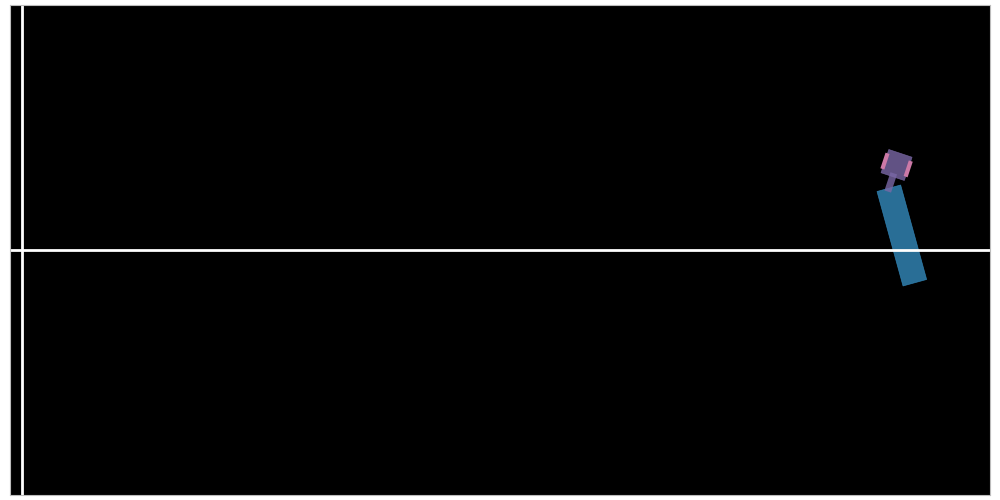

In [6]:
truck = Truck(display=True)

In [8]:
ϕ = deg2rad(0)  # positive left, negative right
truck.step(ϕ)
truck.draw()

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import SGD,Adam
from tqdm import tqdm

In [10]:
# Build expert data set, 

#episodes = 10
angles = list()
states = list()
transitions = list()
truck = Truck(); 
episodes = 10_000  # uncomment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2  
        angles.append([ϕ])
        states.append(initial_state)
        transitions.append(truck.step(ϕ))
        #truck.draw()

100%|██████████| 10000/10000 [00:27<00:00, 365.12it/s]


In [7]:
len(states), len(angles), len(transitions)

(596382, 596382, 596382)

In [11]:
#initialize emulator
state_size = 6
steering_size = 1
hidden_units_1 = 45
class Emulator(nn.Module):
    """
    emulator class so it is easier to understand, and allow gradient flow back to controller once in place. 
    """
    def __init__(self,state_size,steering_size,hidden_units_1): 
        super(Emulator, self).__init__()
        self.fc1 = nn.Linear(steering_size + state_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1,state_size)
        
    def forward(self, steering_angle,observation):
        x = torch.cat([steering_angle,observation])
        x = F.relu(self.fc1(x))
        
        return self.fc2(x)
        
 
    

criterion = nn.MSELoss()
emulator = Emulator(6,1,45)
optimiser_e = SGD(emulator.parameters(), lr=0.005)


In [12]:
tensor_angles = torch.Tensor(angles)
tensor_states = torch.Tensor(states)
tensor_transitions = torch.Tensor(transitions)

In [13]:
#standardize 
mean = tensor_states.mean(0)
std = tensor_states.std(0)
tensor_inputs = (tensor_states - mean) / std
tensor_outputs = (tensor_transitions - mean) / std
angle_mean = tensor_angles.mean(0)
angle_std = tensor_angles.std(0)
tensor_angles = (tensor_angles - angle_mean) / angle_std

In [14]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_angles = tensor_angles[:test_size]
train_outputs = tensor_outputs[:test_size]


test_inputs = tensor_inputs[test_size:]
test_angles = tensor_angles[test_size:]
test_outputs = tensor_outputs[test_size:]

594488 475590


In [15]:
# Train:  regress on output state .. also only doing over 1 epoch, not really a great plan.
cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ = train_angles[i]
    state = train_inputs[i]
    next_state_prediction = emulator(ϕ, state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state) #regress
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 475590, 0.7200863957
1000 / 475590, 0.0791507438
2000 / 475590, 0.0155375758
3000 / 475590, 0.0324862003
4000 / 475590, 0.0334779173
5000 / 475590, 0.0107920561
6000 / 475590, 0.0089614680
7000 / 475590, 0.0378895700
8000 / 475590, 0.0074073486
9000 / 475590, 0.0013294091
10000 / 475590, 0.0129717030
11000 / 475590, 0.0077788276
12000 / 475590, 0.0085256854
13000 / 475590, 0.0017562030
14000 / 475590, 0.0012490381
15000 / 475590, 0.0061991108
16000 / 475590, 0.0007338576
17000 / 475590, 0.0046328264
18000 / 475590, 0.0032780934
19000 / 475590, 0.0041339057
20000 / 475590, 0.0057546268
21000 / 475590, 0.0022281553
22000 / 475590, 0.0031335636
23000 / 475590, 0.0020044355
24000 / 475590, 0.0058557224
25000 / 475590, 0.0022618533
26000 / 475590, 0.0020751718
27000 / 475590, 0.0013792060
28000 / 475590, 0.0040745595
29000 / 475590, 0.0005338732
30000 / 475590, 0.0022971390
31000 / 475590, 0.0050688777
32000 / 475590, 0.0010599942
33000 / 475590, 0.0031010960
34000 / 475590, 0.002037

277000 / 475590, 0.0004807455
278000 / 475590, 0.0002274825
279000 / 475590, 0.0001662371
280000 / 475590, 0.0000403884
281000 / 475590, 0.0002337125
282000 / 475590, 0.0001823791
283000 / 475590, 0.0000718919
284000 / 475590, 0.0002698475
285000 / 475590, 0.0007254981
286000 / 475590, 0.0005198711
287000 / 475590, 0.0003081980
288000 / 475590, 0.0006461896
289000 / 475590, 0.0003158748
290000 / 475590, 0.0002106788
291000 / 475590, 0.0002667547
292000 / 475590, 0.0001427669
293000 / 475590, 0.0008185530
294000 / 475590, 0.0005611515
295000 / 475590, 0.0001854139
296000 / 475590, 0.0002583437
297000 / 475590, 0.0000820451
298000 / 475590, 0.0009307974
299000 / 475590, 0.0002409116
300000 / 475590, 0.0002284962
301000 / 475590, 0.0003212827
302000 / 475590, 0.0003032903
303000 / 475590, 0.0009178682
304000 / 475590, 0.0001431947
305000 / 475590, 0.0001189906
306000 / 475590, 0.0004813778
307000 / 475590, 0.0001293872
308000 / 475590, 0.0001254188
309000 / 475590, 0.0003957762
310000 / 4

In [29]:
# Test
total_loss = 0
with torch.no_grad():
    idx = -1
    for ϕ,state in zip(test_angles, test_inputs):
        idx +=1
        next_state_prediction = emulator(ϕ,state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

ave_test_loss = total_loss/test_size
print(f'Test loss: {ave_test_loss:.10f}')

Test loss: 0.0000389543


# Controller Training

Forward Pass
1. Calculate the next steering signal with the controller
2. Use the actual truck to calculate the next position * == or use emulator! 
3. Repeat steps 1 and 2 until the truck is at the dock or a maximum number of steps $k$ were performed) 

In [69]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

# If you succeed, feel free to send a PR

class Controller(nn.Module):
    """
    Controller class so it is easier to understand, and allow forward prop into emulator. e. 
    """
    def __init__(self,state_size,steering_size,hidden_units_1): 
        super(Controller, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1,steering_size)        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = (torch.tanh(self.fc2(x))) * π / 4 #squashed to correct domain
        return x

controller = Controller(state_size,steering_size,hidden_units_1=25)

optimiser_c = Adam(controller.parameters(), lr = 0.005)

Backward Pass

1. If the maximum number of steps was reached in step 3, do not perform backpropagation.
2. Calculate the sum squared error between the final truck position and the dock.
3. Calculate the derivative of the error wrt the truck state and use backpropagation through time (BPTT) to propagate the error through all emulators and controllers.
4. Update the weights of the controller

In [70]:
def offscreen_loss(ϕ_state,target_state):
    """
    Loss to backprop over if the terminal state was an outside one
    
    key difference between reinforcement learning and this type of control is you now have a differentiable loss. 
    
    Idea is to get as close to target state as possible, a straight truck touching the dock. 
    """
    
    return F.mse_loss(ϕ_state[3:],target_state[3:],reduction = 'sum')

def jackknife_loss(ϕ_state,target_state):
    """
    Loss to backprop over if terminal state is a jackknife
    
    Only computes MSE between the angle observations, a quick way to tell the truck it needs straighten out!
    """
    
    return 10000*F.mse_loss(ϕ_state[2::3],target_state[2::3],reduction = 'sum')


In [ ]:
# Build controller data set

display=False #set to true if you want to see how training progresses. 

truck = Truck(display=display); 
episodes = 80_000  #creating the data set
target_state = torch.Tensor([4, 0, 0, 0, 0, 0]) #cab at 4, all else at 0. This is docking position. 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_c, 'min', factor=0.85,   patience=1500, verbose=True)
force_state = (9,0,0,0)
Js = []
steps = []
controller.train()
emulator.train()
avg_loss = []
avg_steps = []
for episode in range(episodes):
    truck.reset(force_state = force_state)
    #in these commands below I give the problem an easier setup. From here, the truck only needs to back up
    #this slighlty angled position, and from there, prove it can ~learn. 
    #standardize input 
    ϕ_state = torch.Tensor(truck.state())
    ϕ_state = (ϕ_state - mean) / std
    steps_ = 0
    while truck.valid(): # forward step 3
        #forward
        #start at initial, and go to the end 
        ϕ = controller(ϕ_state)
        ϕ_std = (ϕ - angle_mean) / angle_std
        ϕ_state  = emulator(ϕ_std,ϕ_state) #send grad through, but don't break.  
        
        
        true_state = truck.step(ϕ.item())
        if display: #draw how training goes
            truck.draw()
            sleep(.001)
        steps_ +=1
    ϕ_state = ϕ_state*std + mean
    if truck.is_jackknifed():
        loss = jackknife_loss(ϕ_state,target_state) + offscreen_loss(ϕ_state,target_state)
    else:
        loss = offscreen_loss(ϕ_state,target_state)
    
    optimiser_c.zero_grad() #set to zero
    optimiser_e.zero_grad()
    loss.backward() #accumulate over entire graph
    optimiser_c.step()   

    Js.append(loss.item())
    steps.append(steps_)
    scheduler.step(loss)
    avg_loss.append( loss.item())
    avg_steps.append(steps_)
    if episode%1000 == 0:
        print("epoch: {}, avg_loss: {} avg_steps: {}".format(episode, np.mean(avg_loss), np.mean(avg_steps)))

        avg_loss = []
        avg_steps = []


epoch: 0, avg_loss: 45510.64453125 avg_steps: 54.0
epoch: 1000, avg_loss: 8156.939876953125 avg_steps: 37.224
epoch: 2000, avg_loss: 4435.14476171875 avg_steps: 32.208
epoch: 3000, avg_loss: 4234.169811767578 avg_steps: 31.771
epoch: 4000, avg_loss: 3988.6070634765624 avg_steps: 31.0
epoch: 5000, avg_loss: 3946.130234130859 avg_steps: 31.0
epoch: 6000, avg_loss: 3898.9741872558593 avg_steps: 31.0
epoch: 7000, avg_loss: 3837.095672607422 avg_steps: 31.0
epoch: 8000, avg_loss: 3815.9514140625 avg_steps: 31.0
epoch: 9000, avg_loss: 3810.1797846679688 avg_steps: 31.0
epoch: 10000, avg_loss: 3807.690308837891 avg_steps: 31.0


To view the truck in action, I preessed the power button on the plot above, re initialized, and watched it run from this spot. 

<IPython.core.display.Javascript object>


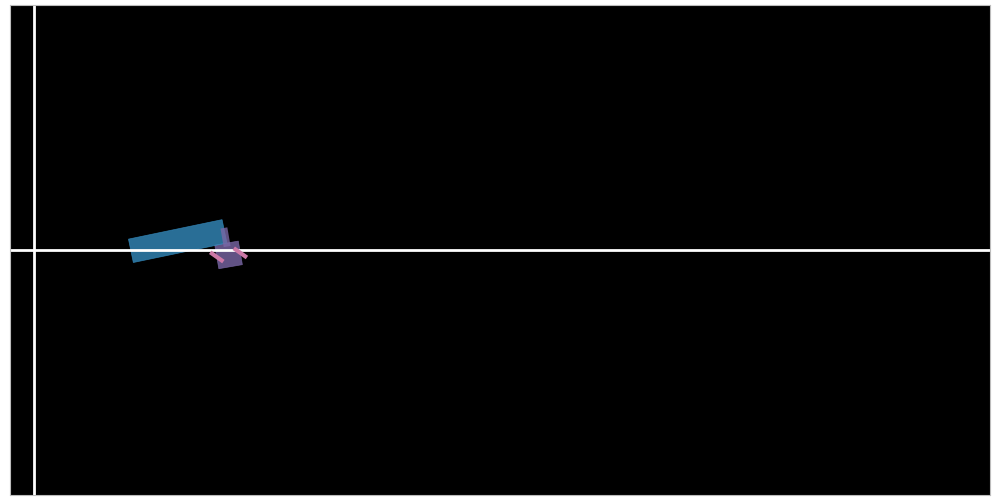

In [66]:
#Test controller:
from time import sleep 
%matplotlib notebook 
controller.eval()
truck = Truck(display=True); 


for i in range(10):
    truck.reset(force_state= force_state)
    
    ϕ_state = torch.Tensor(truck.state())
    ϕ_state = (ϕ_state - mean) / std
    while truck.valid():
        ϕ = controller(ϕ_state)
        ϕ_state = truck.step(ϕ.item())
        ϕ_state = torch.Tensor(ϕ_state)

        ϕ_state = (ϕ_state - mean)/ std
        truck.draw()
        sleep(.001)

In [49]:
truck.state()[3:]

(4.055286379327342, 0.034212782608304515, -0.20461097596181044)

From the above you see it gets \~modestly\~ close to [4,0,0,0,0]